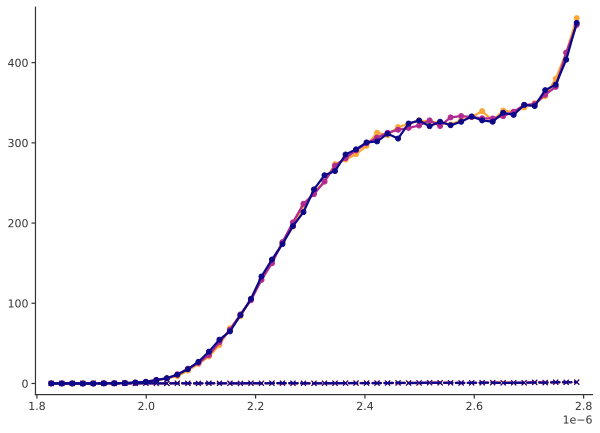

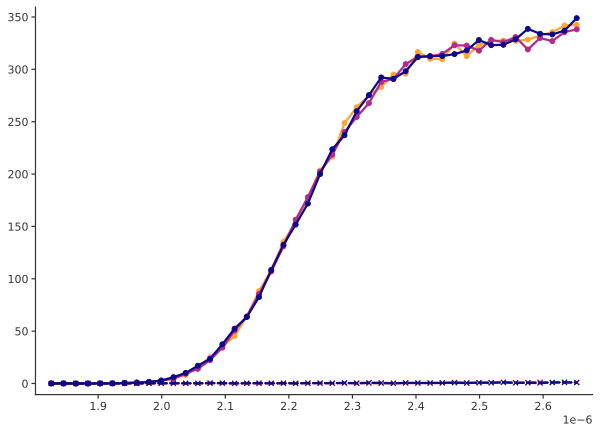

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import re
from dataclasses import dataclass
from typing import Optional, Tuple, List
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from snsphd.viz import phd_style

from snsphd.layout import bisect

colors, swatches = phd_style(jupyterStyle=True)

@dataclass
class PixelData:
    """Data structure for a single pixel's PCR measurements."""
    bias_current: np.ndarray
    counts: np.ndarray
    dark_counts: np.ndarray
    pixel_id: str
    filename: str
    
    def get_scaled_bias_current(self, scale_factor: float = 1020000) -> np.ndarray:
        """Get bias current scaled by the given factor."""
        return self.bias_current / scale_factor

@dataclass
class PlotConfig:
    """Configuration for plotting PCR data."""
    cut_end_points: int = 0
    filter_index: Optional[int] = None
    color: Optional[str] = None
    label: Optional[str] = None
    scale_factor: float = 1.0
    title: Optional[str] = None
    marker_size: float = 5.0
    save_plot: bool = False
    show_plot: bool = True

class PCRDataLoader:
    """Loads and parses PCR data from CSV files into PixelData objects."""
    
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.data = pd.read_csv(filepath)
        self.x_col = self.data.columns[0]
        self.count_cols = sorted([col for col in self.data.columns if col.startswith("Counts_TL")])
        self.dcount_cols = sorted([col for col in self.data.columns if col.startswith("DCounts_TL")])
        self.col_pairs = self._create_column_pairs()
    
    def _create_column_pairs(self) -> dict:
        """Create pairs of count and dark count columns."""
        col_pairs = {}
        for c_col in self.count_cols:
            match = re.match(r"Counts_(.*)", c_col)
            if match:
                identifier = match.group(1)
                d_col_expected = f"DCounts_{identifier}"
                if d_col_expected in self.dcount_cols:
                    col_pairs[identifier] = {"count": c_col, "dcount": d_col_expected}
        return col_pairs
    
    def get_pixel_data(self, pixel_index: int) -> PixelData:
        """Get PixelData for a specific pixel by index."""
        if pixel_index >= len(self.col_pairs):
            raise IndexError(f"Pixel index {pixel_index} out of range. Available pixels: {len(self.col_pairs)}")
        
        pixel_id = list(self.col_pairs.keys())[pixel_index]
        cols = self.col_pairs[pixel_id]
        
        return PixelData(
            bias_current=self.data[self.x_col].values,
            counts=self.data[cols["count"]].values,
            dark_counts=self.data[cols["dcount"]].values,
            pixel_id=pixel_id,
            filename=self.filepath.split("/")[-1]
        )
    
    def get_all_pixels(self) -> List[PixelData]:
        """Get PixelData for all pixels in the file."""
        return [self.get_pixel_data(i) for i in range(len(self.col_pairs))]
    
    def get_pixel_count(self) -> int:
        """Get the number of pixels in the data file."""
        return len(self.col_pairs)

class PCRDataPlotter:
    """Handles PCR data plotting with clean separation of concerns."""
    
    def __init__(self, csv_data: str):
        self.data = pd.read_csv(io.StringIO(csv_data))
        self.x_col = self.data.columns[0]
        self.count_cols = sorted([col for col in self.data.columns if col.startswith("Counts_TL")])
        self.dcount_cols = sorted([col for col in self.data.columns if col.startswith("DCounts_TL")])
        self.col_pairs = self._create_column_pairs()
    
    def _create_column_pairs(self) -> dict:
        """Create pairs of count and dark count columns."""
        col_pairs = {}
        for c_col in self.count_cols:
            match = re.match(r"Counts_(.*)", c_col)
            if match:
                identifier = match.group(1)
                d_col_expected = f"DCounts_{identifier}"
                if d_col_expected in self.dcount_cols:
                    col_pairs[identifier] = {"count": c_col, "dcount": d_col_expected}
        return col_pairs
    
    def plot_on_axes(self, ax: Axes, config: PlotConfig) -> None:
        """Plot data on provided axes with given configuration."""
        if config.filter_index is not None:
            self._plot_single_pair(ax, config)
        else:
            self._plot_all_pairs(ax, config)
        
        # self._configure_axes(ax, config)
    
    def _plot_single_pair(self, ax: Axes, config: PlotConfig) -> None:
        """Plot a single count/dark count pair."""
        if config.filter_index >= len(self.col_pairs):
            return
            
        identifier = list(self.col_pairs.keys())[config.filter_index]
        cols = self.col_pairs[identifier]
        
        # Fix color handling - check if config.color is None instead of using 'or'
        color = config.color if config.color is not None else plt.cm.plasma(0.5)
        label = config.label or cols["count"]
        
        self._plot_pair(ax, cols, color, label, config)
    
    def _plot_all_pairs(self, ax: Axes, config: PlotConfig) -> None:
        """Plot all count/dark count pairs."""
        colors = plt.cm.plasma(np.linspace(0.8, 0, len(self.col_pairs)))
        
        for i, (identifier, cols) in enumerate(self.col_pairs.items()):
            color = colors[i]
            label = cols["count"]
            self._plot_pair(ax, cols, color, label, config)
    
    def _plot_pair(self, ax: Axes, cols: dict, color: str, label: str, config: PlotConfig) -> None:
        """Plot a single count/dark count pair with given styling."""
        cut = config.cut_end_points
        x_data = self.data[self.x_col][:-cut] / 1020000 if cut > 0 else self.data[self.x_col] / 1020000
        
        # Plot counts
        ax.plot(
            x_data,
            self.data[cols["count"]][:-cut] * config.scale_factor if cut > 0 else self.data[cols["count"]] * config.scale_factor,
            marker="o",
            linestyle="-",
            label=label,
            color=color,
            markersize=config.marker_size,
        )
        
        # Plot dark counts
        ax.plot(
            x_data,
            self.data[cols["dcount"]][:-cut] if cut > 0 else self.data[cols["dcount"]],
            marker="x",
            linestyle="--",
            label=f"{label} DCR",
            color=color,
            markersize=config.marker_size,
        )
    
    def _configure_axes(self, ax: Axes, config: PlotConfig) -> None:
        """Configure axes labels, title, legend, etc."""
        ax.set_xlabel("Bias Current (A)")
        ax.set_ylabel("Counts per second (Hz)")
        ax.grid(True)
        ax.legend(fontsize=13, frameon=False, ncol=2)
        
        if config.title:
            ax.set_title(config.title, fontsize=11, fontweight="bold")

class PCRPlotManager:
    """High-level manager for creating and managing PCR plots."""
    
    def __init__(self):
        self.fig: Optional[Figure] = None
        self.ax: Optional[Axes] = None
    
    def create_figure(self, figsize: Tuple[float, float] = (10, 7)) -> 'PCRPlotManager':
        """Create a new figure and axes."""
        self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
        return self
    
    def use_axes(self, fig: Figure, ax: Axes) -> 'PCRPlotManager':
        """Use existing figure and axes."""
        self.fig, self.ax = fig, ax
        return self
    
    def add_file_data(self, filepath: str, config: PlotConfig) -> 'PCRPlotManager':
        """Add data from a file to the current plot."""
        if self.ax is None:
            self.create_figure()
        
        with open(filepath, "r") as file:
            csv_data = file.read()
        
        plotter = PCRDataPlotter(csv_data)
        plotter.plot_on_axes(self.ax, config)
        return self
    
    def add_pixel_data(self, pixel_data: PixelData, config: PlotConfig) -> 'PCRPlotManager':
        """Add PixelData to the current plot."""
        if self.ax is None:
            self.create_figure()
        
        self._plot_pixel_data(pixel_data, config)
        return self
    
    def _plot_pixel_data(self, pixel_data: PixelData, config: PlotConfig) -> None:
        """Plot a single PixelData object."""
        cut = config.cut_end_points
        x_data = pixel_data.get_scaled_bias_current()
        
        if cut > 0:
            x_data = x_data[:-cut]
            counts = pixel_data.counts[:-cut]
            dark_counts = pixel_data.dark_counts[:-cut]
        else:
            counts = pixel_data.counts
            dark_counts = pixel_data.dark_counts
        
        color = config.color if config.color is not None else plt.cm.plasma(0.5)
        label = config.label or pixel_data.pixel_id
        
        # Plot counts
        self.ax.plot(
            x_data,
            counts * config.scale_factor,
            marker="o",
            linestyle="-",
            label=label,
            color=color,
            markersize=config.marker_size,
        )
        
        # Plot dark counts
        self.ax.plot(
            x_data,
            dark_counts,
            marker="x",
            linestyle="--",
            label=f"{label} DCR",
            color=color,
            markersize=config.marker_size,
        )
        
        # Configure axes
        self.ax.set_xlabel("Bias Current (A)")
        self.ax.set_ylabel("Counts per second (HZ)")
        self.ax.grid(True)
        self.ax.legend(fontsize=13, frameon=False, ncol=2)
        
        if config.title:
            self.ax.set_title(config.title, fontsize=11, fontweight="bold")
    
    
    def get_figure(self) -> Tuple[Figure, Axes]:
        """Get the current figure and axes."""
        return self.fig, self.ax

# Example usage with much cleaner API:
def plot_single_file(filepath: str, config: PlotConfig) -> None:
    """Simple function to plot a single file."""
    PCRPlotManager().create_figure().add_file_data(filepath, config)

# Updated simple plotting function
def file_to_graph(path: str, cut_end_points: int = 0, title: str = None):
    """Simple function for single file plotting."""
    config = PlotConfig(
        cut_end_points=cut_end_points,
        title=title or path.split("/")[-1],
        save_plot=False,
        show_plot=True
    )
    plot_single_file(path, config)

# Examples
file_to_graph(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb4_18.24M_1.61TVS1_0.080_0.090_0.100V_264mK.csv",
    7,
    title="pcb 4, 6.23.2025",
)

file_to_graph(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb5_44.38M_1.61TVS1_0.080_0.090_0.100V_258mK.csv",
    14,
    title="pcb 5, 6.23.2025",
)

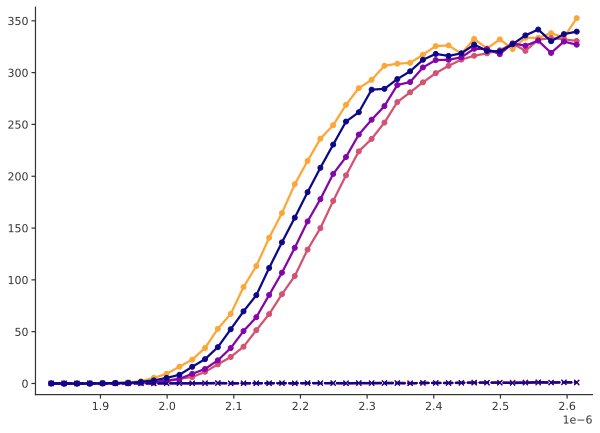

In [2]:
# Much cleaner multi-file plotting
colors = plt.cm.plasma(np.linspace(0.8, 0, 4))

manager = PCRPlotManager().create_figure()

# Add each file with clear, readable configuration
manager.add_file_data(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb1_44.47M_1.61TVS1_0.080_0.090_0.100V_260mK.csv",
    PlotConfig(cut_end_points=16, filter_index=2, color=colors[0], label="pcb 1")
)

manager.add_file_data(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb4_18.24M_1.61TVS1_0.080_0.090_0.100V_264mK.csv",
    PlotConfig(cut_end_points=16, filter_index=1, color=colors[1], label="pcb 4")
)

manager.add_file_data(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb5_44.38M_1.61TVS1_0.080_0.090_0.100V_258mK.csv",
    PlotConfig(cut_end_points=16, filter_index=1, color=colors[2], label="pcb 5")
)

manager.add_file_data(
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb7_44.38M_1.61TVS1_0.080_0.090_0.100V_263mK.csv",
    PlotConfig(cut_end_points=16, filter_index=1, color=colors[3], label="pcb 7", title="4 pixel 1x1mm array, 6.23.2025")
)


In [3]:
# New approach: Load pixel data separately using PCRDataLoader
# This gives us clean separation between data loading and plotting

# Define file paths
file_paths = [
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb1_44.47M_1.61TVS1_0.080_0.090_0.100V_260mK.csv",
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb4_18.24M_1.61TVS1_0.080_0.090_0.100V_264mK.csv",
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb5_44.38M_1.61TVS1_0.080_0.090_0.100V_258mK.csv",
    "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb7_44.38M_1.61TVS1_0.080_0.090_0.100V_263mK.csv"
]

# Load data for each PCB and extract specific pixels
pcb_data_loaders = [PCRDataLoader(path) for path in file_paths]

# Get pixel data for each PCB (assuming we want pixel index 1 for PCB4 and index 2 for PCB1)
pixel_configs = [
    {"loader": pcb_data_loaders[0], "pixel_index": 2, "cut_end_points": 16, "label": "Pixel 1"},
    {"loader": pcb_data_loaders[1], "pixel_index": 1, "cut_end_points": 16, "label": "Pixel 2"},
    {"loader": pcb_data_loaders[2], "pixel_index": 1, "cut_end_points": 16, "label": "Pixel 3"},
    {"loader": pcb_data_loaders[3], "pixel_index": 1, "cut_end_points": 16, "label": "Pixel 4"}
]

# Extract pixel data
pixel_data_list: list[PixelData] = []
for config in pixel_configs:
    pixel_data: PixelData = config["loader"].get_pixel_data(config["pixel_index"])
    pixel_data_list.append((pixel_data, config))

# Display info about loaded pixels
for pixel_data, config in pixel_data_list:
    print(f"{config['label']}: {pixel_data.pixel_id} from {pixel_data.filename}")
    print(f"  Bias current range: {pixel_data.get_scaled_bias_current()[0]:.6f} to {pixel_data.get_scaled_bias_current()[-1]:.6f} A")
    print(f"  Counts range: {pixel_data.counts.min():.1f} to {pixel_data.counts.max():.1f} Hz")
    print(f"  Dark counts range: {pixel_data.dark_counts.min():.1f} to {pixel_data.dark_counts.max():.1f} Hz")
    print()

Pixel 1: TL3(0.100) from R1C3_pcb1_44.47M_1.61TVS1_0.080_0.090_0.100V_260mK.csv
  Bias current range: 0.000002 to 0.000003 A
  Counts range: -0.1 to 12380.5 Hz
  Dark counts range: 0.0 to 8.7 Hz

Pixel 2: TL2(0.090) from R1C3_pcb4_18.24M_1.61TVS1_0.080_0.090_0.100V_264mK.csv
  Bias current range: 0.000002 to 0.000003 A
  Counts range: -0.1 to 2471.7 Hz
  Dark counts range: 0.0 to 2.4 Hz

Pixel 3: TL2(0.090) from R1C3_pcb5_44.38M_1.61TVS1_0.080_0.090_0.100V_258mK.csv
  Bias current range: 0.000002 to 0.000003 A
  Counts range: -0.1 to 6678.4 Hz
  Dark counts range: 0.0 to 4.3 Hz

Pixel 4: TL2(0.090) from R1C3_pcb7_44.38M_1.61TVS1_0.080_0.090_0.100V_263mK.csv
  Bias current range: 0.000002 to 0.000003 A
  Counts range: -0.1 to 9522.7 Hz
  Dark counts range: 0.1 to 6.5 Hz



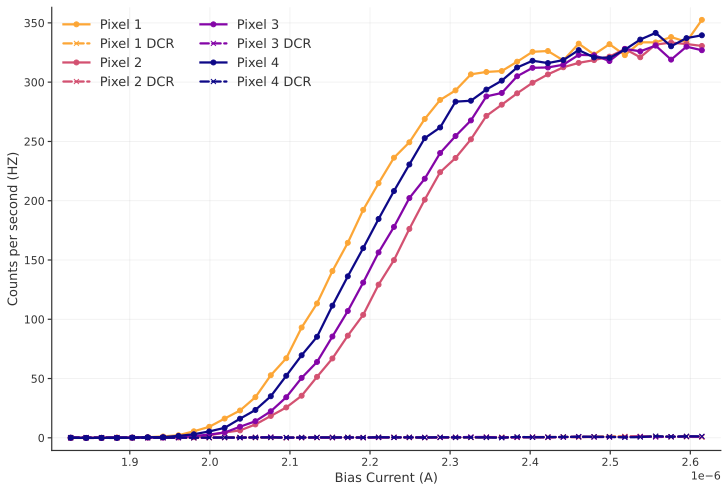

In [4]:
# Now plot using the new PixelData approach
colors = plt.cm.plasma(np.linspace(0.8, 0, 4))

# Plot counts for all 4 pixels
manager = PCRPlotManager().create_figure(figsize=(12, 8))

for i, (pixel_data, config) in enumerate(pixel_data_list):
    plot_config = PlotConfig(
        cut_end_points=config["cut_end_points"],
        color=colors[i],
        label=config["label"],
        marker_size=5.0
    )
    manager.add_pixel_data(pixel_data, plot_config)


Processing entire DCR dataset...


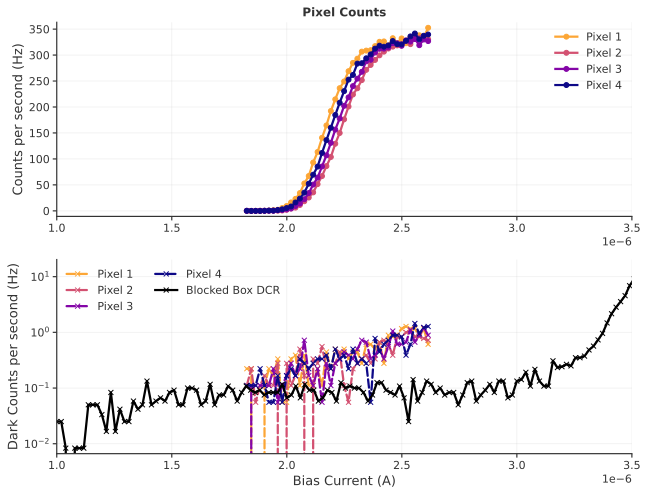

In [5]:
# Create separate plots for counts and dark counts
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fig = plt.figure(figsize=(8, 6))

bottom, top = bisect([0, 0, 1, 1], direction="horiz", offset=0.5, spacing=0.10)

ax_bottom: Axes = fig.add_axes(bottom)
ax_top: Axes = fig.add_axes(top)




# Plot counts only
for i, (pixel_data, config) in enumerate(pixel_data_list):
    cut = config["cut_end_points"]
    x_data = pixel_data.get_scaled_bias_current()
    
    if cut > 0:
        x_data = x_data[:-cut]
        counts = pixel_data.counts[:-cut]
        dark_counts = pixel_data.dark_counts[:-cut]
    else:
        counts = pixel_data.counts
        dark_counts = pixel_data.dark_counts
    
    # Plot counts
    ax_top.plot(
        x_data,
        counts,
        marker="o",
        linestyle="-",
        label=config["label"],
        color=colors[i],
        markersize=5.0,
    )
    
    # Plot dark counts
    ax_bottom.plot(
        x_data,
        dark_counts,
        marker="x",
        linestyle="--",
        label=config["label"],
        color=colors[i],
        markersize=5.0,
    )

# Configure counts plot
# ax_top.set_xlabel("Bias Current (A)")
ax_top.set_ylabel("Counts per second (Hz)")
ax_top.set_title("Pixel Counts", fontsize=12, fontweight="bold")
ax_top.grid(True)
ax_top.legend(fontsize=11, frameon=False)

# Configure dark counts plot
ax_bottom.set_xlabel("Bias Current (A)")
ax_bottom.set_ylabel("Dark Counts per second (Hz)")
# ax_bottom.set_title("Dark Count Rate (DCR)", fontsize=12, fontweight="bold")
ax_bottom.grid(True)
ax_bottom.legend(fontsize=11, frameon=False)
ax_bottom.set_yscale("log")  # Log scale for DCR



# Function to efficiently process the large DCR CSV file
def analyze_dcr_csv_structure(filepath):
    """
    Analyze the structure of a DCR CSV file without reading the entire file into memory.
    Returns information about the number of columns and basic statistics.
    """
    import csv
    
    with open(filepath, 'r') as file:
        # Read just the first line to get column count
        first_line = file.readline().strip()
        num_columns = first_line.count(',') + 1
        
        # Parse the header to understand column structure
        header = first_line.split(',')
        bias_current_col = header[0]
        dcr_cols = header[1:]
        
        print(f"File: {filepath}")
        print(f"Total columns: {num_columns}")
        print(f"Bias current column: {bias_current_col}")
        print(f"DCR columns: {len(dcr_cols)}")
        print(f"First few DCR columns: {dcr_cols[:5]}")
        print(f"Last few DCR columns: {dcr_cols[-5:]}")
        
        # Read a few data rows to understand the structure
        file.seek(0)  # Reset to beginning
        csv_reader = csv.reader(file)
        header_row = next(csv_reader)  # Skip header
        
        sample_rows = []
        for i, row in enumerate(csv_reader):
            if i < 5:  # Read first 5 data rows
                sample_rows.append(row)
            else:
                break
        
        print(f"\nSample data rows:")
        for i, row in enumerate(sample_rows):
            bias_current = float(row[0])
            dcr_values = [float(x) for x in row[1:]]
            non_zero_count = sum(1 for x in dcr_values if x != 0.0)
            total_dcr = sum(dcr_values)
            
            print(f"Row {i+1}: Bias={bias_current:.4f}, Non-zero DCR bins={non_zero_count}, Total DCR={total_dcr:.3f}")
    
    return num_columns, header

def process_dcr_data_efficiently(filepath, max_rows=None):
    """
    Process DCR data efficiently by reading row by row and computing statistics.
    Returns bias currents and total DCR values.
    """
    import csv
    
    bias_currents = []
    total_dcr_values = []
    
    with open(filepath, 'r') as file:
        csv_reader = csv.reader(file)
        header = next(csv_reader)  # Skip header
        
        for row_idx, row in enumerate(csv_reader):
            if max_rows and row_idx >= max_rows:
                break
                
            bias_current = float(row[0])
            # if there's any bursts of dark count (likely caused by switching 
            # bias current source) then count it as 1 count in 1/10th of a second
            dcr_values = [float(x) if float(x) < 40 else 10.0 for x in row[1:]]
            total_dcr = sum(dcr_values)/ len(dcr_values) if dcr_values else 0.0
            
            bias_currents.append(bias_current)
            total_dcr_values.append(total_dcr)
    
    return np.array(bias_currents), np.array(total_dcr_values)



# Analyze the DCR file structure
dcr_file_path_1 = (
    "../data/R1C3_DCR_7.7.25/dcr_pcb4_18.24M_trigger_-0.030_Tstart_250mK.csv"
)
# num_cols, header = analyze_dcr_csv_structure(dcr_file_path_1)

dcr_file_path_2 = (
    "../data/R1C3_DCR_7.7.25/dcr_pcb4_18.24M_trigger_-0.030_Tstart_265mK_2nd_DCR.csv"
)


# Now let's process the entire DCR dataset efficiently
print("Processing entire DCR dataset...")
bias_currents, total_dcr = process_dcr_data_efficiently(dcr_file_path_1)

bias_currents_2, total_dcr_2 = process_dcr_data_efficiently(dcr_file_path_2)

total_dcr = (total_dcr_2) / 1


 # Plot dark counts
ax_bottom.plot(
    bias_currents_2/1e6,
    total_dcr,
    marker="x",
    linestyle="-",
    color="black",
    markersize=5.0,
    label = "Blocked Box DCR"
)

ax_top.set_xlim(1.0e-6, 3.5e-6)
ax_bottom.set_xlim(1.0e-6, 3.5e-6)

ax_bottom.legend(fontsize=11, frameon=False, ncol=2)
fig.savefig("../out/mm_square/PCR_DCR_1x1mm.png", dpi=300, bbox_inches="tight")
fig.savefig("../out/mm_square/PCR_DCR_1x1mm.pdf", dpi=300, bbox_inches="tight")

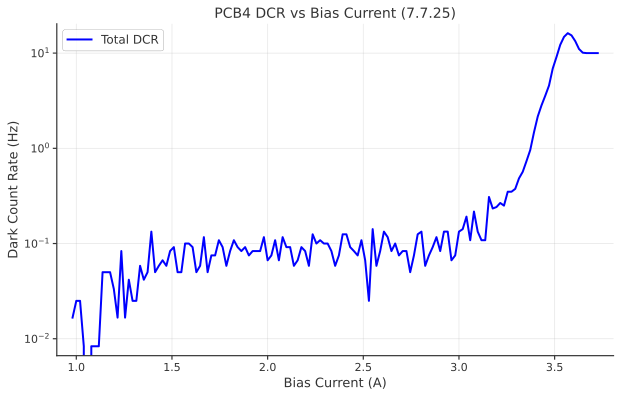

In [6]:

# Plot the DCR data
fig = plt.figure(figsize=(10, 6))
plt.plot(bias_currents, total_dcr, 'b-', linewidth=2, label='Total DCR')
plt.xlabel('Bias Current (A)')
plt.ylabel('Dark Count Rate (Hz)')
plt.title('PCB4 DCR vs Bias Current (7.7.25)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.show()


fig.savefig("../out/mm_square/DCR_1x1mm.png", dpi=300, bbox_inches="tight")

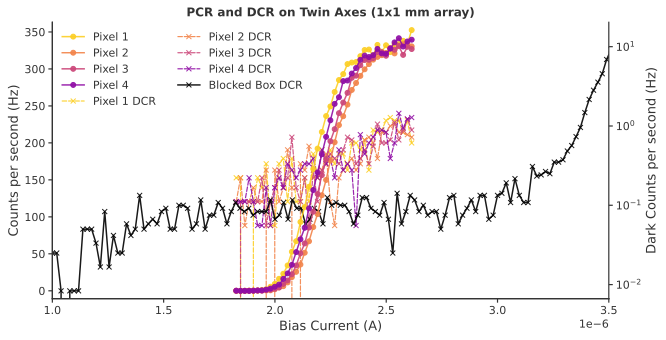

In [7]:
# Combined PCR (left y-axis) and DCR (right y-axis) plot
# This uses existing variables: `pixel_data_list` for PCR and `bias_currents_2/total_dcr` (or fallback to `bias_currents/total_dcr`) for DCR.

# Safety checks
have_pixels = (
    "pixel_data_list" in globals()
    and isinstance(pixel_data_list, list)
    and len(pixel_data_list) > 0
)
have_dcr_2 = "bias_currents_2" in globals() and "total_dcr" in globals()
have_dcr_1 = "bias_currents" in globals() and "total_dcr" in globals()

if not have_pixels:
    raise RuntimeError(
        "pixel_data_list is not defined. Run the earlier cells that load PCR pixel data."
    )

# Choose DCR source (external aggregate DCR)
if have_dcr_2:
    dcr_x = np.array(bias_currents_2, dtype=float) / 1e6  # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
elif have_dcr_1:
    dcr_x = np.array(bias_currents, dtype=float) / 1e6  # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
else:
    dcr_x, dcr_y = None, None

# Prepare figure and twin axes
fig, ax_left = plt.subplots(1, figsize=(10, 5))
ax_right = ax_left.twinx()
ax_left.set_zorder(1)  # Keep left axis on top for mouseover
ax_left.patch.set_visible(False)
ax_right.spines["right"].set_visible(True)

# Colors for PCR/DCR per-pixel traces
colors_local = plt.cm.plasma(np.linspace(0.9, 0.3, len(pixel_data_list)))

# Plot PCR counts (left) and per-pixel DCR (right) inside the same loop
for i, (pixel_data, cfg) in enumerate(pixel_data_list):
    cut = cfg["cut_end_points"]
    x_data = pixel_data.get_scaled_bias_current()  # A
    counts = pixel_data.counts
    dcr_pixel = pixel_data.dark_counts
    label = cfg.get("label", pixel_data.pixel_id)

    if cut and cut > 0:
        x_data = x_data[:-cut]
        counts = counts[:-cut]
        dcr_pixel = dcr_pixel[:-cut]

    # PCR counts on left axis
    ax_left.plot(
        x_data,
        counts,
        marker="o",
        linestyle="-",
        label=label,
        color=colors_local[i],
        markersize=5.0,
        linewidth=1.5,
        alpha=0.9,
    )

    # Per-pixel DCR on right axis
    ax_right.plot(
        x_data,
        dcr_pixel,
        marker="x",
        linestyle="--",
        label=f"{label} DCR",
        color=colors_local[i],
        markersize=5.0,
        linewidth=1.2,
        alpha=0.9,
    )

# Optional: overlay external aggregate DCR as a reference (black)
if dcr_x is not None and dcr_y is not None and len(dcr_x) == len(dcr_y):
    ax_right.plot(
        dcr_x,
        dcr_y,
        marker="x",
        linestyle="-",
        color="black",
        markersize=5.0,
        linewidth=1.5,
        label="Blocked Box DCR",
        alpha=0.9,
    )

# Labels and limits
ax_left.set_xlabel("Bias Current (A)")
ax_left.set_ylabel("Counts per second (Hz)")
ax_right.set_ylabel("Dark Counts per second (Hz)")

# Match prior x-range used in earlier cells
ax_left.set_xlim(1.0e-6, 3.5e-6)
ax_right.set_xlim(1.0e-6, 3.5e-6)

# Right axis on log scale for DCR
ax_right.set_yscale("log")

# Grids and style
# ax_right.grid(True, which="both", alpha=0.3)

# Build a combined legend
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
combined_handles = handles_left + handles_right
combined_labels = labels_left + labels_right
if combined_handles:
    ax_left.legend(
        combined_handles,
        combined_labels,
        fontsize=11,
        frameon=False,
        loc="best",
        ncol=2,
    )

# Title
ax_left.set_title(
    "PCR and DCR on Twin Axes (1x1 mm array)", fontsize=12, fontweight="bold"
)

# Save figures
out_png = "../out/mm_square/PCR_DCR_1x1mm_combined.png"
out_pdf = "../out/mm_square/PCR_DCR_1x1mm_combined.pdf"
try:
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
except Exception as e:
    # Saving is best-effort; still show the figure
    print(f"Warning: could not save figure: {e}")

plt.show()

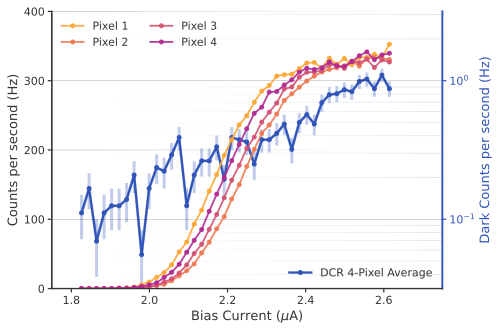

In [8]:
# Combined PCR (left y-axis) and DCR (right y-axis) plot (with segmented, fading grid lines)
# This cell is a copy for experimentation with custom grid fades.
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from util.faded_lines import draw_faded_hline

# Safety checks
have_pixels = 'pixel_data_list' in globals() and isinstance(pixel_data_list, list) and len(pixel_data_list) > 0
have_dcr_2 = 'bias_currents_2' in globals() and 'total_dcr' in globals()
have_dcr_1 = 'bias_currents' in globals() and 'total_dcr' in globals()


right_axis_color = "#3054b8"

if not have_pixels:
    raise RuntimeError("pixel_data_list is not defined. Run the earlier cells that load PCR pixel data.")

# Choose DCR source (external aggregate DCR)
if have_dcr_2:
    dcr_x = np.array(bias_currents_2, dtype=float) / 1e6  # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
elif have_dcr_1:
    dcr_x = np.array(bias_currents, dtype=float) / 1e6    # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
else:
    dcr_x, dcr_y = None, None

ax_right = None
ax_left = None


# Prepare figure and twin axes
fig, ax_left = plt.subplots(1, figsize=(7, 5))
ax_right = ax_left.twinx()
ax_left.set_zorder(1)  # Keep left axis on top for mouseover
ax_left.patch.set_visible(False)
ax_right.spines['right'].set_visible(True)
ax_right.spines['right'].set_linewidth(1.9)

# Colors for PCR/DCR per-pixel traces
colors_local = plt.cm.plasma(np.linspace(0.8, 0.4, len(pixel_data_list)))

# ---- Coordinate coupling (linear left vs log right) ----
# Left axis: 0..400 with 100 spacing
ax_left.set_ylim(0, 400)
ax_left.yaxis.set_major_locator(MultipleLocator(100))

# Right axis: log scale from 3.162e-2 to 3.162e0 so that
# 0,100,200,300,400 on the left align with 3.162e-2,1e-1,3.162e-1,1,3.162 on the right
ax_right.set_yscale("log")
ax_right.set_ylim(3.162e-2, 3.162e0)

# Only show powers-of-ten ticks (remove 3.1×10^n ticks)
ymin_r, ymax_r = ax_right.get_ylim()
exp_min = int(np.ceil(np.log10(ymin_r)))
exp_max = int(np.floor(np.log10(ymax_r)))
pow_ticks = [10 ** e for e in range(exp_min, exp_max + 1)]
ax_right.yaxis.set_major_locator(FixedLocator(pow_ticks))


# We'll draw our own grid, so turn off the built-in one
ax_left.grid(False)
ax_right.grid(False)

# Plot PCR counts (left) and collect per-pixel DCR for averaging
x_list = []
dcr_list = []
for i, (pixel_data, cfg) in enumerate(pixel_data_list):
    cut = cfg["cut_end_points"]
    x_data = pixel_data.get_scaled_bias_current()  # A
    counts = pixel_data.counts
    dcr_pixel = pixel_data.dark_counts
    label = cfg.get("label", pixel_data.pixel_id)

    if cut and cut > 0:
        x_data = x_data[:-cut]
        counts = counts[:-cut]
        dcr_pixel = dcr_pixel[:-cut]

    # PCR counts on left axis
    ax_left.plot(
        x_data*1e6,
        counts,
        marker="o",
        linestyle="-",
        label=label,
        color=colors_local[i],
        markersize=4.0,
        linewidth=1.8,
        alpha=0.9,
    )

    # Collect DCR for averaging later
    x_list.append(np.asarray(x_data))
    dcr_list.append(np.asarray(dcr_pixel))

# Compute and plot average DCR (right axis) with Poisson error bars
if dcr_list:
    min_len = min(len(arr) for arr in dcr_list)
    # Align by trimming the tail; bias current sequences match across files except for cuts
    x_stack = np.vstack([x[:min_len] for x in x_list])
    dcr_stack = np.vstack([y[:min_len] for y in dcr_list])
    x_mean = np.mean(x_stack, axis=0)
    dcr_mean = np.mean(dcr_stack, axis=0)

    # Poisson 1σ error bars for averaged rate: sqrt(R / T_eff)
    # Each series uses T_single = 18 s
    n_series = len(dcr_list)
    T_single = 18.0  # seconds
    T_eff = T_single * n_series

    # Ensure non-negative; on log axes the lower bar must keep the value > 0
    yerr = np.sqrt(np.clip(dcr_mean, a_min=0, a_max=None) / T_eff)
    yerr_upper = yerr
    yerr_lower = np.minimum(yerr_upper, np.maximum(dcr_mean - 1e-9, 0))

    ax_right.errorbar(
        x_mean * 1e6,
        dcr_mean,
        yerr=np.vstack([yerr_lower, yerr_upper]),
        color=right_axis_color,
        linestyle="-",
        marker="none",
        linewidth=3.0,
        markersize=5,
        capsize=0,
        alpha=0.3,
    )

    ax_right.plot(
        x_mean * 1e6,
        dcr_mean,
        color=right_axis_color,
        linestyle="-",
        label="DCR 4-Pixel Average",
        marker="o",
        markersize=4,
    )

# ----- Segmented, fading horizontal grid lines -----

# Fix x-range and sync twin axes
ax_left.set_xlim(1.75, 2.75)
ax_right.set_xlim(*ax_left.get_xlim())

# Determine x-range once
x0, x1 = ax_left.get_xlim()

# 1) Fade-left-to-right for left-axis lines at 100 and 300 (strong near left, fade before right)
for y_lin in (0, 200, 400):
    if 0 <= y_lin <= 400:
        draw_faded_hline(
            ax_left,
            y_lin,
            x0,
            x1,
            n_segments=160,
            base_color='black',
            alpha_max=0.26,
            lw=0.7,
            fade_from="left",
            zorder=0.1,
        )

# Optional subtle anchors at 0, 200, 400
for y_lin in (100, 300):
    xs = np.array([[x0, y_lin], [x1, y_lin]])
    lc = LineCollection([xs], colors=[mcolors.to_rgba("0.0", 0.3)], linewidths=0.5, zorder=0)
    ax_left.add_collection(lc)

# 2) Fade-right-to-left for log minor grid lines on the right axis
#    Use y = (2..9) * 10^k within the current y-limits
ymin, ymax = ax_right.get_ylim()
min_exp = int(np.floor(np.log10(ymin)))
max_exp = int(np.floor(np.log10(ymax)))
for k in range(min_exp, max_exp + 1):
    for m in range(2, 10):
        y_minor = m * (10 ** k)
        if ymin <= y_minor <= ymax:
            draw_faded_hline(
                ax_right,
                y_minor,
                x0,
                x1,
                n_segments=160,
                base_color=right_axis_color,
                alpha_max=0.25,
                lw=0.5,
                fade_from="right",
                zorder=0.05,
            )

# Labels and limits
ax_left.set_xlabel(r"Bias Current ($\mu$A)")
ax_left.set_ylabel("Counts per second (Hz)")
ax_right.set_ylabel("Dark Counts per second (Hz)")

# Color right axis blue to match the DCR line
ax_right.spines["right"].set_color(right_axis_color)
ax_right.tick_params(axis="y", colors=right_axis_color)
ax_right.yaxis.label.set_color(right_axis_color)

# Build a combined legend
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
# combined_handles = handles_left + handles_right
# combined_labels = labels_left + labels_right
# if combined_handles:
#     ax_left.legend(combined_handles, combined_labels, fontsize=11, frameon=False, loc="best", ncol=2)


ax_left.legend(
    handles_left,
    labels_left,
    fontsize=11,
    frameon=False,
    loc="upper left",
    ncol=2,
)


ax_right.legend(
    handles_right,
    labels_right,
    fontsize=11,
    frameon=False,
    loc="lower right",
    ncol=2,
)


# Save figures
out_png = "../out/mm_square/PCR_DCR_1x1mm_combined_faded_grid.png"
out_pdf = "../out/mm_square/PCR_DCR_1x1mm_combined_faded_grid.pdf"
try:
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
except Exception as e:
    print(f"Warning: could not save figure: {e}")

plt.show()

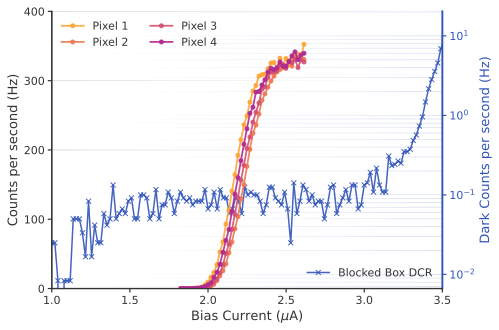

In [9]:
# Combined PCR (left y-axis) and DCR (right y-axis) plot (with segmented, fading grid lines)
# This cell is a copy for experimentation with custom grid fades.

from util.faded_lines import draw_faded_hline

# Safety checks
have_pixels = (
    "pixel_data_list" in globals()
    and isinstance(pixel_data_list, list)
    and len(pixel_data_list) > 0
)
have_dcr_2 = "bias_currents_2" in globals() and "total_dcr" in globals()
have_dcr_1 = "bias_currents" in globals() and "total_dcr" in globals()


right_axis_color = "#3054b8"

if not have_pixels:
    raise RuntimeError(
        "pixel_data_list is not defined. Run the earlier cells that load PCR pixel data."
    )

# Choose DCR source (external aggregate DCR)
if have_dcr_2:
    dcr_x = np.array(bias_currents_2, dtype=float) / 1e6  # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
elif have_dcr_1:
    dcr_x = np.array(bias_currents, dtype=float) / 1e6  # convert to A
    dcr_y = np.array(total_dcr, dtype=float)
else:
    dcr_x, dcr_y = None, None

# Prepare figure and twin axes
fig, ax_left = plt.subplots(1, figsize=(7, 5))
ax_right = ax_left.twinx()
ax_left.set_zorder(1)  # Keep left axis on top for mouseover
ax_left.patch.set_visible(False)
ax_right.spines["right"].set_visible(True)
ax_right.spines["right"].set_linewidth(1.9)

# Colors for PCR/DCR per-pixel traces
colors_local = plt.cm.plasma(np.linspace(0.8, 0.4, len(pixel_data_list)))

# ---- Coordinate coupling (linear left vs log right) ----
# Left axis: 0..400 with 100 spacing
ax_left.set_ylim(0, 400)
ax_left.yaxis.set_major_locator(MultipleLocator(100))

# Right axis: log scale from 3.162e-2 to 3.162e0 so that
# 0,100,200,300,400 on the left align with 3.162e-2,1e-1,3.162e-1,1,3.162 on the right
ax_right.set_yscale("log")
# ax_right.set_ylim(3.162e-2, 3.162e0)



# We'll draw our own grid, so turn off the built-in one
ax_left.grid(False)
ax_right.grid(False)

# Plot PCR counts (left) and collect per-pixel DCR for averaging
x_list = []
dcr_list = []
for i, (pixel_data, cfg) in enumerate(pixel_data_list):
    cut = cfg["cut_end_points"]
    x_data = pixel_data.get_scaled_bias_current()  # A
    counts = pixel_data.counts
    dcr_pixel = pixel_data.dark_counts
    label = cfg.get("label", pixel_data.pixel_id)

    if cut and cut > 0:
        x_data = x_data[:-cut]
        counts = counts[:-cut]
        dcr_pixel = dcr_pixel[:-cut]

    # PCR counts on left axis
    ax_left.plot(
        x_data * 1e6,
        counts,
        marker="o",
        linestyle="-",
        label=label,
        color=colors_local[i],
        markersize=4.0,
        linewidth=1.8,
        alpha=0.9,
    )

    # Collect DCR for averaging later
    x_list.append(np.asarray(x_data))
    dcr_list.append(np.asarray(dcr_pixel))


ax_right.plot(
    dcr_x * 1e6,
    dcr_y,
    marker="x",
    linestyle="-",
    color=right_axis_color,
    markersize=5.0,
    linewidth=1.5,
    label="Blocked Box DCR",
    alpha=0.9,
)

# Compute and plot average DCR (right axis) with Poisson error bars
if dcr_list:
    min_len = min(len(arr) for arr in dcr_list)
    # Align by trimming the tail; bias current sequences match across files except for cuts
    x_stack = np.vstack([x[:min_len] for x in x_list])
    dcr_stack = np.vstack([y[:min_len] for y in dcr_list])
    x_mean = np.mean(x_stack, axis=0)
    dcr_mean = np.mean(dcr_stack, axis=0)

    # Poisson 1σ error bars for averaged rate: sqrt(R / T_eff)
    # Each series uses T_single = 18 s
    n_series = len(dcr_list)
    T_single = 18.0  # seconds
    T_eff = T_single * n_series

    # Ensure non-negative; on log axes the lower bar must keep the value > 0
    yerr = np.sqrt(np.clip(dcr_mean, a_min=0, a_max=None) / T_eff)
    yerr_upper = yerr
    yerr_lower = np.minimum(yerr_upper, np.maximum(dcr_mean - 1e-9, 0))



# ----- Segmented, fading horizontal grid lines -----

# Fix x-range and sync twin axes
ax_left.set_xlim(1, 3.5)
ax_right.set_xlim(*ax_left.get_xlim())

# Determine x-range once
x0, x1 = ax_left.get_xlim()

# 1) Fade-left-to-right for left-axis lines at 100 and 300 (strong near left, fade before right)
for y_lin in (0, 200, 300, 400):
    if 0 <= y_lin <= 400:
        draw_faded_hline(
            ax_left,
            y_lin,
            x0,
            x1,
            n_segments=160,
            base_color='black',
            alpha_max=0.2,
            lw=0.7,
            fade_from="left",
            zorder=0.1,
        )

# # Optional subtle anchors at 0, 200, 400
# for y_lin in (100, 300):
#     xs = np.array([[x0, y_lin], [x1, y_lin]])
#     lc = LineCollection(
#         [xs], colors=[mcolors.to_rgba("0.0", 0.3)], linewidths=0.5, zorder=0
#     )
#     ax_left.add_collection(lc)

# 2) Fade-right-to-left for log minor grid lines on the right axis
#    Use y = (2..9) * 10^k within the current y-limits
ymin, ymax = ax_right.get_ylim()
min_exp = int(np.floor(np.log10(ymin)))
max_exp = int(np.floor(np.log10(ymax)))
for k in range(min_exp, max_exp + 1):
    for m in range(2, 11):
        y_minor = m * (10**k)
        if ymin <= y_minor <= ymax:
            draw_faded_hline(
                ax_right,
                y_minor,
                x0,
                x1,
                n_segments=160,
                base_color=right_axis_color,
                alpha_max=0.28,
                lw=0.5,
                fade_from="right",
                zorder=0.05,
            )

# Labels and limits
ax_left.set_xlabel(r"Bias Current ($\mu$A)")
ax_left.set_ylabel("Counts per second (Hz)")
ax_right.set_ylabel("Dark Counts per second (Hz)")

# Color right axis blue to match the DCR line
ax_right.spines["right"].set_color(right_axis_color)
ax_right.tick_params(axis="y", colors=right_axis_color)
ax_right.yaxis.label.set_color(right_axis_color)

# Build a combined legend
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
# combined_handles = handles_left + handles_right
# combined_labels = labels_left + labels_right
# if combined_handles:
#     ax_left.legend(
#         combined_handles,
#         combined_labels,
#         fontsize=11,
#         frameon=False,
#         loc="best",
#         ncol=2,
#     )


ax_left.legend(
        handles_left,
        labels_left,
        fontsize=11,
        frameon=False,
        loc="upper left",
        ncol=2,
    )


ax_right.legend(handles_right,
        labels_right,
        fontsize=11,
        frameon=False,
        loc="lower right",
        ncol=2,
    )

# Save figures
out_png = "../out/mm_square/PCR_DCR_1x1mm_combined_faded_grid_with_base_DCR.png"
out_pdf = "../out/mm_square/PCR_DCR_1x1mm_combined_faded_grid_with_base_DCR.pdf"
try:
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
except Exception as e:
    print(f"Warning: could not save figure: {e}")

plt.show()

In [ ]:
from util.load_Pc230518 import load_pcr_file, clean_data


pcr = load_pcr_file("../data/Pa231025/R1C3/pcrcurve_cr_20231207-095706.txt")

pcr_cleaned = clean_data(pcr, integrations_per_setting=5)


dark = load_pcr_file("../data/Pa231025/R1C3/pcrcurve_cr_20231207-095706_dark.txt")
dark_cleaned = clean_data(dark, integrations_per_setting=5)

# plt.plot(thresholds["coalesced_bias"], thresholds["coalesced_counts"])

from snsphd.viz import phd_style

colors, swatches = phd_style(jupyterStyle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
pcr.keys()

dict_keys(['unixtime_s', 'bias_V', 'sense_voltage_V', 'counts_Photons', 'threshold_mV', 'min_peak_voltage_mV', 'peak_to_peak_voltage_mV', 'bias', 'counts'])

ValueError: operands could not be broadcast together with shapes (178,) (0,) 

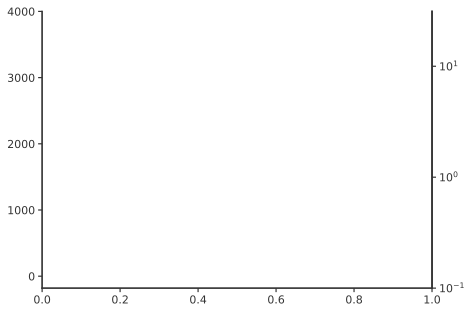

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from util.faded_lines import draw_faded_hline


arrow = False


# Helper to extract dwell times (keeps prior logic)
def get_times_array(dic):
    arr = dic["unixtime_s"] - np.roll(dic["unixtime_s"], 1)
    cleaned_times = []
    for item in arr:
        if (item > 9) and (item < 20):
            cleaned_times.append(item)
    bifurcated_times = []
    i = 0
    for item in cleaned_times:
        i += 1
        if i == 3:
            bifurcated_times.append(item)
            i = 0
    return np.array(bifurcated_times)


# Dwell times for PCR and DCR series
times_pcr = get_times_array(pcr_cleaned)
times_dark = get_times_array(dark_cleaned)

right_axis_color = "#3054b8"  # blue for right axis/DCR

# Figure and twin axes
fig, ax_left = plt.subplots(1, figsize=(7, 5))
ax_right = ax_left.twinx()
ax_left.set_zorder(1)  # Keep left axis on top for mouseover
ax_left.patch.set_visible(False)
ax_right.spines["right"].set_visible(True)
ax_right.spines["right"].set_linewidth(1.9)

# Color map for PCR traces (plasma)
colors_local = plt.cm.plasma(np.linspace(0.8, 0.4, 1))

# Preserve existing axis styles from this workflow
ax_left.set_ylim(-180, 4000)
ax_left.yaxis.set_major_locator(MultipleLocator(1000))
ax_right.set_yscale("log")
ax_right.set_ylim(1e-1, 3.12e1)

# We'll draw our own faded grids
ax_left.grid(False)
ax_right.grid(False)

# Data window
right_clip = -6

# ---- Plot data ----
## PCR (left axis)
ax_left.plot(
    -pcr_cleaned["bias_TS2"][:right_clip],
    pcr_cleaned["counts_TS2"][:right_clip] / times_pcr[: (right_clip + 1)],
    marker="o",
    linestyle="-",
    label=r"29$\mu$m",
    color=colors_local[0],
    markersize=4.0,
    linewidth=1.8,
    alpha=0.9,
)

## DCR (right axis) with error bars
counts_TS2 = dark_cleaned["counts_TS2"][:right_clip]
time_TS2 = times_dark[: (right_clip + 1)]
dcr_rate = counts_TS2 / time_TS2
yerr = np.sqrt(np.clip(counts_TS2, a_min=0, a_max=None)) / time_TS2
yerr_upper = yerr
yerr_lower = np.minimum(yerr_upper, np.maximum(dcr_rate - 1e-9, 0))
ax_right.errorbar(
    -dark_cleaned["bias_TS2"][:right_clip],
    dcr_rate,
    yerr=np.vstack([yerr_lower, yerr_upper]),
    color=right_axis_color,
    linestyle="-",
    marker="none",
    linewidth=3.0,
    markersize=5,
    capsize=0,
    alpha=0.3,
)
ax_right.plot(
    -dark_cleaned["bias_TS2"][:right_clip],
    dcr_rate,
    color=right_axis_color,
    linestyle="-",
    label="DCR",
    marker="o",
    markersize=4,
    linewidth=2.0,
)

# Sync x-range across twins
ax_right.set_xlim(*ax_left.get_xlim())
x0, x1 = ax_left.get_xlim()

# ---- Faded horizontal grid lines ----
## Left axis: fade left-to-right at major ticks
ymin_l, ymax_l = ax_left.get_ylim()
for y_lin in ax_left.get_yticks():
    if ymin_l <= y_lin <= ymax_l:
        draw_faded_hline(
            ax_left,
            y_lin,
            x0,
            x1,
            n_segments=160,
            base_color="black",
            alpha_max=0.26,
            lw=0.7,
            fade_from="left",
            zorder=0.1,
        )

## Right axis (log): minor grid lines fade right-to-left
ymin_r, ymax_r = ax_right.get_ylim()
min_exp = int(np.floor(np.log10(ymin_r)))
max_exp = int(np.floor(np.log10(ymax_r)))
for k in range(min_exp, max_exp + 1):
    for m in range(2, 10):
        y_minor = m * (10**k)
        if ymin_r <= y_minor <= ymax_r:
            draw_faded_hline(
                ax_right,
                y_minor,
                x0,
                x1,
                n_segments=160,
                base_color=right_axis_color,
                alpha_max=0.25,
                lw=0.5,
                fade_from="right",
                zorder=0.05,
            )

# Also draw major powers-of-ten grid lines on the right, same style as minor
for e in range(min_exp, max_exp + 1):
    y_major = 10**e
    if ymin_r <= y_major <= ymax_r:
        draw_faded_hline(
            ax_right,
            y_major,
            x0,
            x1,
            n_segments=160,
            base_color=right_axis_color,
            alpha_max=0.25,  # same fade as minor per request
            lw=0.5,  # same line width as minor
            fade_from="right",
            zorder=0.06,
        )

# Labels
ax_left.set_xlabel(r"Bias Current ($\mu$A)")
ax_left.set_ylabel("Counts per second (Hz)")
ax_right.set_ylabel("Dark Counts per second (Hz)")

# Match right axis color to its data
ax_right.spines["right"].set_color(right_axis_color)
ax_right.tick_params(axis="y", colors=right_axis_color)
ax_right.yaxis.label.set_color(right_axis_color)

# Legends
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
if handles_left:
    ax_left.legend(
        handles_left, labels_left, fontsize=11, frameon=False, loc="upper left", ncol=1
    )
if handles_right:
    ax_right.legend(
        handles_right,
        labels_right,
        fontsize=11,
        frameon=False,
        loc="lower right",
        ncol=1,
    )


if arrow:
    right_axis_color_light = "#c2cdea"
    ax_left.annotate(
        "",
        xytext=(0.215, 1000),
        xy=(0.25, 1000),
        arrowprops=dict(
            arrowstyle="->",
            lw=3,
            mutation_scale=30,
            color=right_axis_color_light,
            alpha=1,
        ),
    )
    leg_d = ax_right.get_legend()
    if leg_d is not None:
        leg_d.set_loc("lower right")

# Save figures
# st = "_arrow" if arrow else ""
# out_png = f"../out/single_wire/single_wire_faded_grid{st}.png"
# out_pdf = f"../out/single_wire/single_wire_faded_grid{st}.pdf"
# try:
#     fig.savefig(out_png, dpi=300, bbox_inches="tight")
#     fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
# except Exception as e:
#     print(f"Warning: could not save figure: {e}")

plt.show()

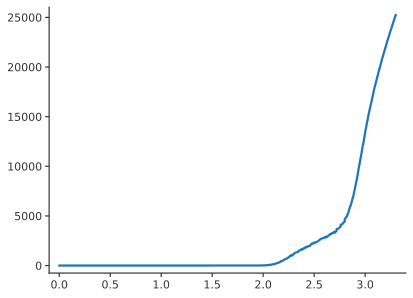

In [48]:
plt.plot(-pcr_cleaned["bias_TS2"], pcr_cleaned["counts_TS2"])
# plt.plot(pcr_cleaned["counts_TS3"])